# Binance Data Science & Algorithm Internship
##Take Home Assessment - Give Me Some Credit
## <i>Author: Qian Liu &nbsp;&nbsp;&nbsp;  Date: 11/15/2022</i>
-------------------------------------------

### This report contains Qian's work on the Give me some credit Kaggle dataset as per requied by the Data Science & Algorithm Internship interview.

##Preparation

In [250]:
#Setup
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [276]:
#Import
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier, plot_importance
import statsmodels.api as sm
from scipy import stats

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [252]:
#Import data
train = pd.read_csv("cs-training.csv")
test = pd.read_csv("cs-test.csv")

y_train = train[["SeriousDlqin2yrs"]]
y_test = test[["SeriousDlqin2yrs"]]

In [253]:
#Browse the data
train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [254]:
train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [255]:
#Rename columns
train=train.drop(["Unnamed: 0"], axis = 1)
train = train.rename(columns={"RevolvingUtilizationOfUnsecuredLines": "Total_balance"})

test=test.drop(["Unnamed: 0", "SeriousDlqin2yrs"], axis = 1)
test = test.rename(columns={"RevolvingUtilizationOfUnsecuredLines": "Total_balance"})


##Q1: What are the factors that have high correlation with the probability of loan default?

In [256]:
corr = train.corr(method='pearson', min_periods=1)
corr.style.background_gradient(cmap='RdBu_r')

,SeriousDlqin2yrs,Total_balance,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001802,-0.115386,0.125587,-0.007602,-0.019746,-0.029669,0.117175,-0.007038,0.102261,0.046048
Total_balance,-0.001802,1.000000,-0.005898,-0.001314,0.003961,0.007124,-0.011281,-0.001061,0.006235,-0.001048,0.001557
age,-0.115386,-0.005898,1.000000,-0.062995,0.024188,0.037717,0.147705,-0.061005,0.033150,-0.057159,-0.213303
NumberOfTime30-59DaysPastDueNotWorse,0.125587,-0.001314,-0.062995,1.000000,-0.006542,-0.010217,-0.055312,0.983603,-0.030565,0.987005,-0.002680
DebtRatio,-0.007602,0.003961,0.024188,-0.006542,1.000000,-0.028712,0.049565,-0.008320,0.120046,-0.007533,-0.040673
MonthlyIncome,-0.019746,0.007124,0.037717,-0.010217,-0.028712,1.000000,0.091455,-0.012743,0.124959,-0.011116,0.062647
NumberOfOpenCreditLinesAndLoans,-0.029669,-0.011281,0.147705,-0.055312,0.049565,0.091455,1.000000,-0.079984,0.433959,-0.071077,0.065322
NumberOfTimes90DaysLate,0.117175,-0.001061,-0.061005,0.983603,-0.008320,-0.012743,-0.079984,1.000000,-0.045205,0.992796,-0.010176
NumberRealEstateLoansOrLines,-0.007038,0.006235,0.033150,-0.030565,0.120046,0.124959,0.433959,-0.045205,1.000000,-0.039722,0.124684
NumberOfTime60-89DaysPastDueNotWorse,0.102261,-0.001048,-0.057159,0.987005,-0.007533,-0.011116,-0.071077,0.992796,-0.039722,1.000000,-0.010922


A1: NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate are highly correlated. After looking into the values, there are 264 + 5 people who always have 98/96 in all three columns, with Total_balance 0.99999999, which very likely to be dummy values. I think we need to remove all the unreasonable rows to check the corrolation. Remove all these rows only for checking the corrolation.

In [257]:
#Remove unreasonable rows
corr_train = train[train["NumberOfTimes90DaysLate"] != 98]
corr_train = corr_train[corr_train["NumberOfTimes90DaysLate"] != 96]

In [258]:
#Check Corr again
corr = corr_train.corr(method='pearson', min_periods=1)
corr.style.background_gradient(cmap='RdBu_r')

,SeriousDlqin2yrs,Total_balance,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001744,-0.112968,0.274550,-0.007069,-0.019119,-0.024231,0.314535,-0.003959,0.268130,0.047360
Total_balance,-0.001744,1.000000,-0.005955,-0.002819,0.003955,0.007118,-0.011368,-0.001807,0.006207,-0.002441,0.001547
age,-0.112968,-0.005955,1.000000,-0.071867,0.023860,0.037340,0.144747,-0.082384,0.031258,-0.069846,-0.214590
NumberOfTime30-59DaysPastDueNotWorse,0.274550,-0.002819,-0.071867,1.000000,0.003491,-0.001914,0.080069,0.218147,0.042762,0.305876,0.063617
DebtRatio,-0.007069,0.003955,0.023860,0.003491,1.000000,-0.028736,0.049183,-0.009848,0.119861,-0.004195,-0.040791
MonthlyIncome,-0.019119,0.007118,0.037340,-0.001914,-0.028736,1.000000,0.091026,-0.019882,0.124709,-0.011535,0.062511
NumberOfOpenCreditLinesAndLoans,-0.024231,-0.011368,0.144747,0.080069,0.049183,0.091026,1.000000,-0.093869,0.432664,-0.021906,0.064561
NumberOfTimes90DaysLate,0.314535,-0.001807,-0.082384,0.218147,-0.009848,-0.019882,-0.093869,1.000000,-0.062472,0.294638,0.030655
NumberRealEstateLoansOrLines,-0.003959,0.006207,0.031258,0.042762,0.119861,0.124709,0.432664,-0.062472,1.000000,-0.020697,0.124321
NumberOfTime60-89DaysPastDueNotWorse,0.268130,-0.002441,-0.069846,0.305876,-0.004195,-0.011535,-0.021906,0.294638,-0.020697,1.000000,0.036750


Based on the corrolation table, we could see NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTimes90DaysLate are highly corrolated with probability of loan default. Age also has some negative corrolation with the probability of loan default.

##Q2: Are there interaction effects occurring among the variables?

In [259]:
#Checking missing values
train.isnull().any()

SeriousDlqin2yrs                        False
Total_balance                           False
age                                     False
NumberOfTime30-59DaysPastDueNotWorse    False
DebtRatio                               False
MonthlyIncome                            True
NumberOfOpenCreditLinesAndLoans         False
NumberOfTimes90DaysLate                 False
NumberRealEstateLoansOrLines            False
NumberOfTime60-89DaysPastDueNotWorse    False
NumberOfDependents                       True
dtype: bool

In [260]:
#Drop missing value & y
train_inter = train.dropna()
train_inter

,SeriousDlqin2yrs,Total_balance,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149994,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,0.0
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [261]:
train_inter.describe()

,SeriousDlqin2yrs,Total_balance,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,120269.000000,120269.000000,120269.000000,120269.000000,120269.000000,1.202690e+05,120269.000000,120269.000000,120269.000000,120269.000000,120269.000000
mean,0.069486,5.899873,51.289792,0.381769,26.598777,6.670221e+03,8.758475,0.211925,1.054519,0.187829,0.851832
std,0.254280,257.040685,14.426684,3.499234,424.446457,1.438467e+04,5.172835,3.465276,1.149273,3.447901,1.148391
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.035084,40.000000,0.000000,0.143388,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.177282,51.000000,0.000000,0.296023,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.579428,61.000000,0.000000,0.482559,8.249000e+03,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,50708.000000,103.000000,98.000000,61106.500000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [262]:
#Clean outlier
def boundry(x):
    upper = x.quantile(0.975)
    return upper

columns= ["Total_balance", "NumberOfTime30-59DaysPastDueNotWorse", "DebtRatio", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"]

for i in train_inter.columns:
    upper = boundry(train_inter[i])
    train_inter = train_inter[train_inter[i]<=upper]
train_inter.describe()


,SeriousDlqin2yrs,Total_balance,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,99699.000000,99699.000000,99699.000000,99699.000000,99699.000000,99699.000000,99699.000000,99699.000000,99699.000000,99699.000000,99699.000000
mean,0.047413,0.305900,50.706105,0.162670,0.338535,6044.846558,8.322571,0.030953,0.950852,0.031053,0.808022
std,0.212521,0.330091,13.814376,0.438038,0.294124,3437.078369,4.390373,0.173192,0.873037,0.173463,1.069547
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.032951,40.000000,0.000000,0.140815,3500.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.159469,50.000000,0.000000,0.286159,5373.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.517603,61.000000,0.000000,0.454385,8000.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,1.000000,81.000000,2.000000,2.385027,18333.000000,21.000000,1.000000,3.000000,1.000000,4.000000


In [263]:
y_inter = train_inter["SeriousDlqin2yrs"]
train_inter = train_inter.drop("SeriousDlqin2yrs",axis = 1)
train_inter_new = train_inter.copy()
for i,col in enumerate(train_inter.columns):
  for j in range(i+1, len(train_inter.columns)):
    name = col + "_" + train_inter.columns[j]
    train_inter_new[name] = train_inter[col] * train_inter[train_inter.columns[j]]

In [264]:
#Regression
X2 = sm.add_constant(train_inter_new)
est = sm.OLS(y_inter, X2)
est2 = est.fit()

res_df = pd.DataFrame(est2.pvalues)

res_df[res_df[0]<0.05].index

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Index(['Total_balance', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'Total_balance_age',
       'Total_balance_NumberOfTime30-59DaysPastDueNotWorse',
       'Total_balance_MonthlyIncome',
       'Total_balance_NumberOfOpenCreditLinesAndLoans',
       'Total_balance_NumberOfTimes90DaysLate',
       'Total_balance_NumberRealEstateLoansOrLines',
       'Total_balance_NumberOfTime60-89DaysPastDueNotWorse',
       'Total_balance_NumberOfDependents', 'age_DebtRatio',
       'age_NumberOfTimes90DaysLate',
       'NumberOfTime30-59DaysPastDueNotWorse_MonthlyIncome',
       'NumberOfTime30-59DaysPastDueNotWorse_NumberOfTime60-89DaysPastDueNotWorse',
       'DebtRatio_NumberOfOpenCreditLinesAndLoans',
       'DebtRatio_NumberOfTimes90DaysLate',
       'DebtRatio_NumberRealEstateLoansOrLines',
       'MonthlyIncome_NumberRealEstateLoansOrLines',
       'MonthlyIncome_NumberOfTime60-89Da

Interaction effects occurring among the variables listed as below:

* Total_balance vs. age,
*Total_balance vs. NumberOfTime30-59DaysPastDueNotWorse,
*Total_balance vs. MonthlyIncome,
*Total_balance vs. NumberOfOpenCreditLinesAndLoans,
*Total_balance vs. NumberOfTimes90DaysLate,
*Total_balance vs. NumberRealEstateLoansOrLines,
*Total_balance vs. NumberOfTime60-89DaysPastDueNotWorse,
*Total_balance vs. NumberOfDependents, age vs. DebtRatio,
*age vs. NumberOfTimes90DaysLate,
*NumberOfTime30-59DaysPastDueNotWorse vs. MonthlyIncome,
*NumberOfTime30-59DaysPastDueNotWorse vs. NumberOfTime60-89DaysPastDueNotWorse,
*DebtRatio vs. NumberOfOpenCreditLinesAndLoans,
*DebtRatio vs. NumberOfTimes90DaysLate,
*DebtRatio vs. NumberRealEstateLoansOrLines,
*MonthlyIncome vs. NumberRealEstateLoansOrLines,
*MonthlyIncome vs. NumberOfTime60-89DaysPastDueNotWorse,
*MonthlyIncome vs. NumberOfDependents,
*NumberOfOpenCreditLinesAndLoans vs. NumberOfTime60-89DaysPastDueNotWorse,
*NumberOfTimes90DaysLate vs. NumberOfDependents

##Q3: Any other preliminary analysis of the given dataset?

In [265]:
train.head()

,SeriousDlqin2yrs,Total_balance,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [266]:
#Fill in the missing data
imputer = IterativeImputer(random_state=21)
train=pd.DataFrame(imputer.fit_transform(train),columns = train.columns)

test=pd.DataFrame(imputer.fit_transform(test),columns = test.columns)
train

,SeriousDlqin2yrs,Total_balance,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1.0,0.766127,45.0,2.0,0.802982,9120.000000,13.0,0.0,6.0,0.0,2.0
1,0.0,0.957151,40.0,0.0,0.121876,2600.000000,4.0,0.0,0.0,0.0,1.0
2,0.0,0.658180,38.0,1.0,0.085113,3042.000000,2.0,1.0,0.0,0.0,0.0
3,0.0,0.233810,30.0,0.0,0.036050,3300.000000,5.0,0.0,0.0,0.0,0.0
4,0.0,0.907239,49.0,1.0,0.024926,63588.000000,7.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0.0,0.040674,74.0,0.0,0.225131,2100.000000,4.0,0.0,1.0,0.0,0.0
149996,0.0,0.299745,44.0,0.0,0.716562,5584.000000,4.0,0.0,1.0,0.0,2.0
149997,0.0,0.246044,58.0,0.0,3870.000000,3228.669364,18.0,0.0,1.0,0.0,0.0
149998,0.0,0.000000,30.0,0.0,0.000000,5716.000000,4.0,0.0,0.0,0.0,0.0


In [267]:
#Clean outlier
def boundry(x):
    upper = x.quantile(0.975)
    return upper

columns= ["Total_balance", "NumberOfTime30-59DaysPastDueNotWorse", "DebtRatio", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"]

for i in columns:
  upper = boundry(train[i])
  train.loc[train[i]>upper,i] = upper
  test.loc[test[i]>upper,i] = upper

In [268]:
train.describe()

,SeriousDlqin2yrs,Total_balance,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,0.319196,52.295207,0.212873,292.293501,6.205549e+03,8.452760,0.055587,1.018240,0.050693,0.750961
std,0.249746,0.349481,14.771866,0.523017,798.368761,1.305671e+04,5.145951,0.229123,1.129771,0.219371,1.102491
min,0.000000,0.000000,0.000000,0.000000,0.000000,-3.437691e+05,0.000000,0.000000,0.000000,0.000000,-5.238815
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.466000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.000000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,7.441948e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,1.000000,109.000000,2.000000,3489.025000,3.008750e+06,58.000000,1.000000,54.000000,1.000000,20.000000


In [269]:
train[(train["NumberOfOpenCreditLinesAndLoans"] == 0) & (train["NumberRealEstateLoansOrLines"] == 0) & train["Total_balance"] > 0]

,SeriousDlqin2yrs,Total_balance,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
176,0.0,1.0,69.0,0.0,0.005319,2255.000000,0.0,1.0,0.0,0.0,3.000000
238,0.0,1.0,28.0,0.0,0.000000,3767.308218,0.0,0.0,0.0,0.0,0.953499
243,0.0,1.0,68.0,0.0,0.040493,6000.000000,0.0,0.0,0.0,0.0,0.000000
331,0.0,1.0,29.0,0.0,0.000000,3117.921946,0.0,0.0,0.0,0.0,0.000000
381,0.0,1.0,22.0,0.0,130.000000,3497.222861,0.0,0.0,0.0,0.0,1.051571
...,...,...,...,...,...,...,...,...,...,...,...
149679,0.0,1.0,59.0,1.0,0.835846,596.000000,0.0,1.0,0.0,0.0,0.000000
149736,0.0,1.0,35.0,0.0,1205.000000,2029.471458,0.0,0.0,0.0,0.0,0.000000
149769,0.0,1.0,23.0,2.0,0.000000,2426.782990,0.0,1.0,0.0,1.0,0.587135
149791,0.0,1.0,32.0,0.0,0.000000,1000.000000,0.0,0.0,0.0,0.0,2.000000


A3: 1) There exist people who have neither open credit lines/loans nor real estate loans/lines and still have almost 100% balance on their credit cards. \
2) In Q2, I've found monthly income and Number of dependents two columns have missing values. I simply dropped all the NAs in Q2, but this will harm modeling. Therefore, I used a regression-based imputer from sklearn to fill in the blank here. \
3) In Q2, I counted all the data points which have a higher than 0.975 percentile as the outlier. I dropped all of them in Q2 because they could have seriously influence the result of a OLS regression model.
However, the rest data won't be able to capture all the cases for prediction, and this is not practical for the test set. So I replace all the outliers with upper or lower bounds, and this could be applied to the test set as well.\
4) People who have an integer debt ratio come with a missing value in the monthly income. A valid guess is when we don't have monthly income information, the debt ratio will be calculated by dividing by 1.

#Part 2

In [270]:
#Train the model with CV
skf = StratifiedKFold(n_splits=5)
all_scores, all_labels = [], []
train = train.drop("SeriousDlqin2yrs",axis=1)
for train_index, test_index in skf.split(train, y_train):
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
    # clf = LGBMClassifier(learning_rate=0.025,random_state=21, n_estimators=200,objective='binary',metrics='auc',is_unbalance=True)
    clf = LGBMClassifier(is_unbalance = True,max_depth=8,learning_rate=0.025,random_state=21,n_estimators=180,feature_fraction=0.6)
    clf.fit(X_train, Y_train)
    all_scores += clf.predict_proba(X_test)[:,1].tolist()
    all_labels += Y_test.values.tolist()
all_scores = np.array(all_scores)
all_preds = np.zeros_like(all_scores)
all_preds[all_scores>0.5] = 1 # Empirical cutoff instead of 0.5
print("AUC: %.4f, Accuracy: %.4f, Precision: %.4f, Recall: %.4f, f1: %.4f"%(roc_auc_score(all_labels,all_scores),accuracy_score(all_labels,all_preds),precision_score(all_labels,all_preds),recall_score(all_labels,all_preds),f1_score(all_labels,all_preds)))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

AUC: 0.8705, Accuracy: 0.8054, Precision: 0.2240, Recall: 0.7756, f1: 0.3476


In [271]:
best_clf = LGBMClassifier(is_unbalance = True,max_depth=8,learning_rate=0.025,random_state=21,n_estimators=180,feature_fraction=0.6).fit(train, y_train)
y_test['Id'] = y_test.index+1
y_test['SeriousDlqin2yrs'] = best_clf.predict_proba(test)[:,1]
y_test = y_test.rename(columns={"SeriousDlqin2yrs": "Probability"})

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [272]:
y_test

,Probability,Id
0,0.488488,1
1,0.323069,2
2,0.196156,3
3,0.543410,4
4,0.550049,5
...,...,...
101498,0.287120,101499
101499,0.849713,101500
101500,0.034595,101501
101501,0.372548,101502


In [273]:
y_test = y_test[['Id','Probability']]
y_test.to_csv("Prediction.csv",index=False)

Q1: Tell us how you validate your model and why you chose such evaluation technique(s). \
A: I used a cross validation, StratifiedKFold, with 5 folds to validate my model. I choose this because there is heavy imbalance in the training data. 

Q2: What is AUC? Why do you think AUC was used as the evaluation metric for this challenge? What other metrics do you think would also be suitable for this competition? \
A: AUC measure the area under the ROC curve, which reports the performance of the model in distinguishing between classes. The other metrics I choose are Accuracy, Precision, Recall and f1.

Q3: Short explanation of what you tried. What worked and what did not work (ie. you might have tried different features/models before the final one). \
A3: I've tried to adopt random forest as my model, but the speed is too slow, which is not efficient. I also tried to drop features which are relatively corrolated. But it didn't help with the AUC. I also tuned hyperparameters to get the best performance.

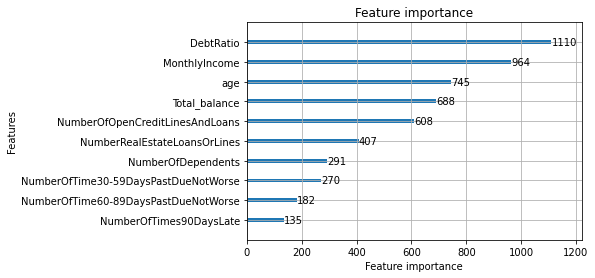

In [277]:
plot_importance(best_clf)

Q4: What insight(s) do you have from your model(s)? \
A4: From fraph, we could see Deberatio, MonthlyIncome have extremely high importance, and age, Total_balance have moderate importance.